In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- IMPORT SHARED UTILS ---
%load_ext autoreload
%autoreload 2
from db_utils import get_engine

# Visualization settings
plt.style.use('dark_background')
%config InlineBackend.figure_format = 'retina'

# Connect to DB
engine = get_engine()

print("⏳ Fetching Cohort Data...")

query = """
WITH first_purchase AS (
    SELECT customer_unique_id,
    MIN(DATE_TRUNC('month', o.order_purchase_timestamp::timestamp))::date AS cohort_month
    FROM orders o
    JOIN customers c ON o.customer_id = c.customer_id
    GROUP BY 1
),
cohort_size AS (
    SELECT cohort_month, COUNT(DISTINCT customer_unique_id) as initial_users
    FROM first_purchase
    GROUP BY 1
),
activities AS (
    SELECT c.customer_unique_id,
    DATE_TRUNC('month', o.order_purchase_timestamp::timestamp)::date AS activity_month
    FROM orders o
    JOIN customers c ON o.customer_id = c.customer_id
),
retention AS (
    SELECT 
        fp.cohort_month,
        a.activity_month,
        cs.initial_users,
        -- Calculate month lag (0, 1, 2...)
        EXTRACT(YEAR FROM age(a.activity_month, fp.cohort_month)) * 12 + 
        EXTRACT(MONTH FROM age(a.activity_month, fp.cohort_month)) AS period_number,
        COUNT(DISTINCT fp.customer_unique_id) AS active_users
    FROM first_purchase fp
    JOIN activities a ON fp.customer_unique_id = a.customer_unique_id
    JOIN cohort_size cs ON fp.cohort_month = cs.cohort_month
    GROUP BY 1, 2, 3, 4
)
SELECT * FROM retention 
WHERE period_number <= 12
ORDER BY cohort_month, period_number;
"""

df_raw = pd.read_sql(query, engine)
df_raw.head()

⏳ Fetching Cohort Data...


,cohort_month,activity_month,initial_users,period_number,active_users
0,2016-09-01,2016-09-01,4,0.0,4
1,2016-10-01,2016-10-01,321,0.0,321
2,2016-10-01,2017-04-01,321,6.0,1
3,2016-10-01,2017-07-01,321,9.0,1
4,2016-10-01,2017-09-01,321,11.0,1


In [2]:
print("🔄 Processing Retention Matrix...")

# Pivot table
pivot = df_raw.pivot_table(index='cohort_month', columns='period_number', values='active_users')

# Calculate percentages (divide by initial cohort size aka month 0)
cohort_sizes = pivot.iloc[:, 0]
retention_matrix = pivot.divide(cohort_sizes, axis=0) * 100

# Formatting Index
retention_matrix.index = pd.to_datetime(retention_matrix.index).strftime('%Y-%m')

# Cleanup
cols_to_drop = [c for c in [0, 0.0] if c in retention_matrix.columns]
retention_matrix = retention_matrix.drop(columns=cols_to_drop)

# Filter: Focus on 2017-2018 (when data stabilized)
retention_matrix = retention_matrix[retention_matrix.index >= '2017-01']

# Check result
retention_matrix.iloc[:5, :5]

🔄 Processing Retention Matrix...


period_number,1.0,2.0,3.0,4.0,5.0
cohort_month,,,,,
2017-01,0.392670,0.261780,0.130890,0.392670,0.130890
2017-02,0.228311,0.285388,0.114155,0.399543,0.114155
2017-03,0.493171,0.379363,0.379363,0.341426,0.151745
2017-04,0.595238,0.212585,0.170068,0.340136,0.255102
2017-05,0.500556,0.500556,0.389321,0.305895,0.333704


📊 Generating Heatmap...


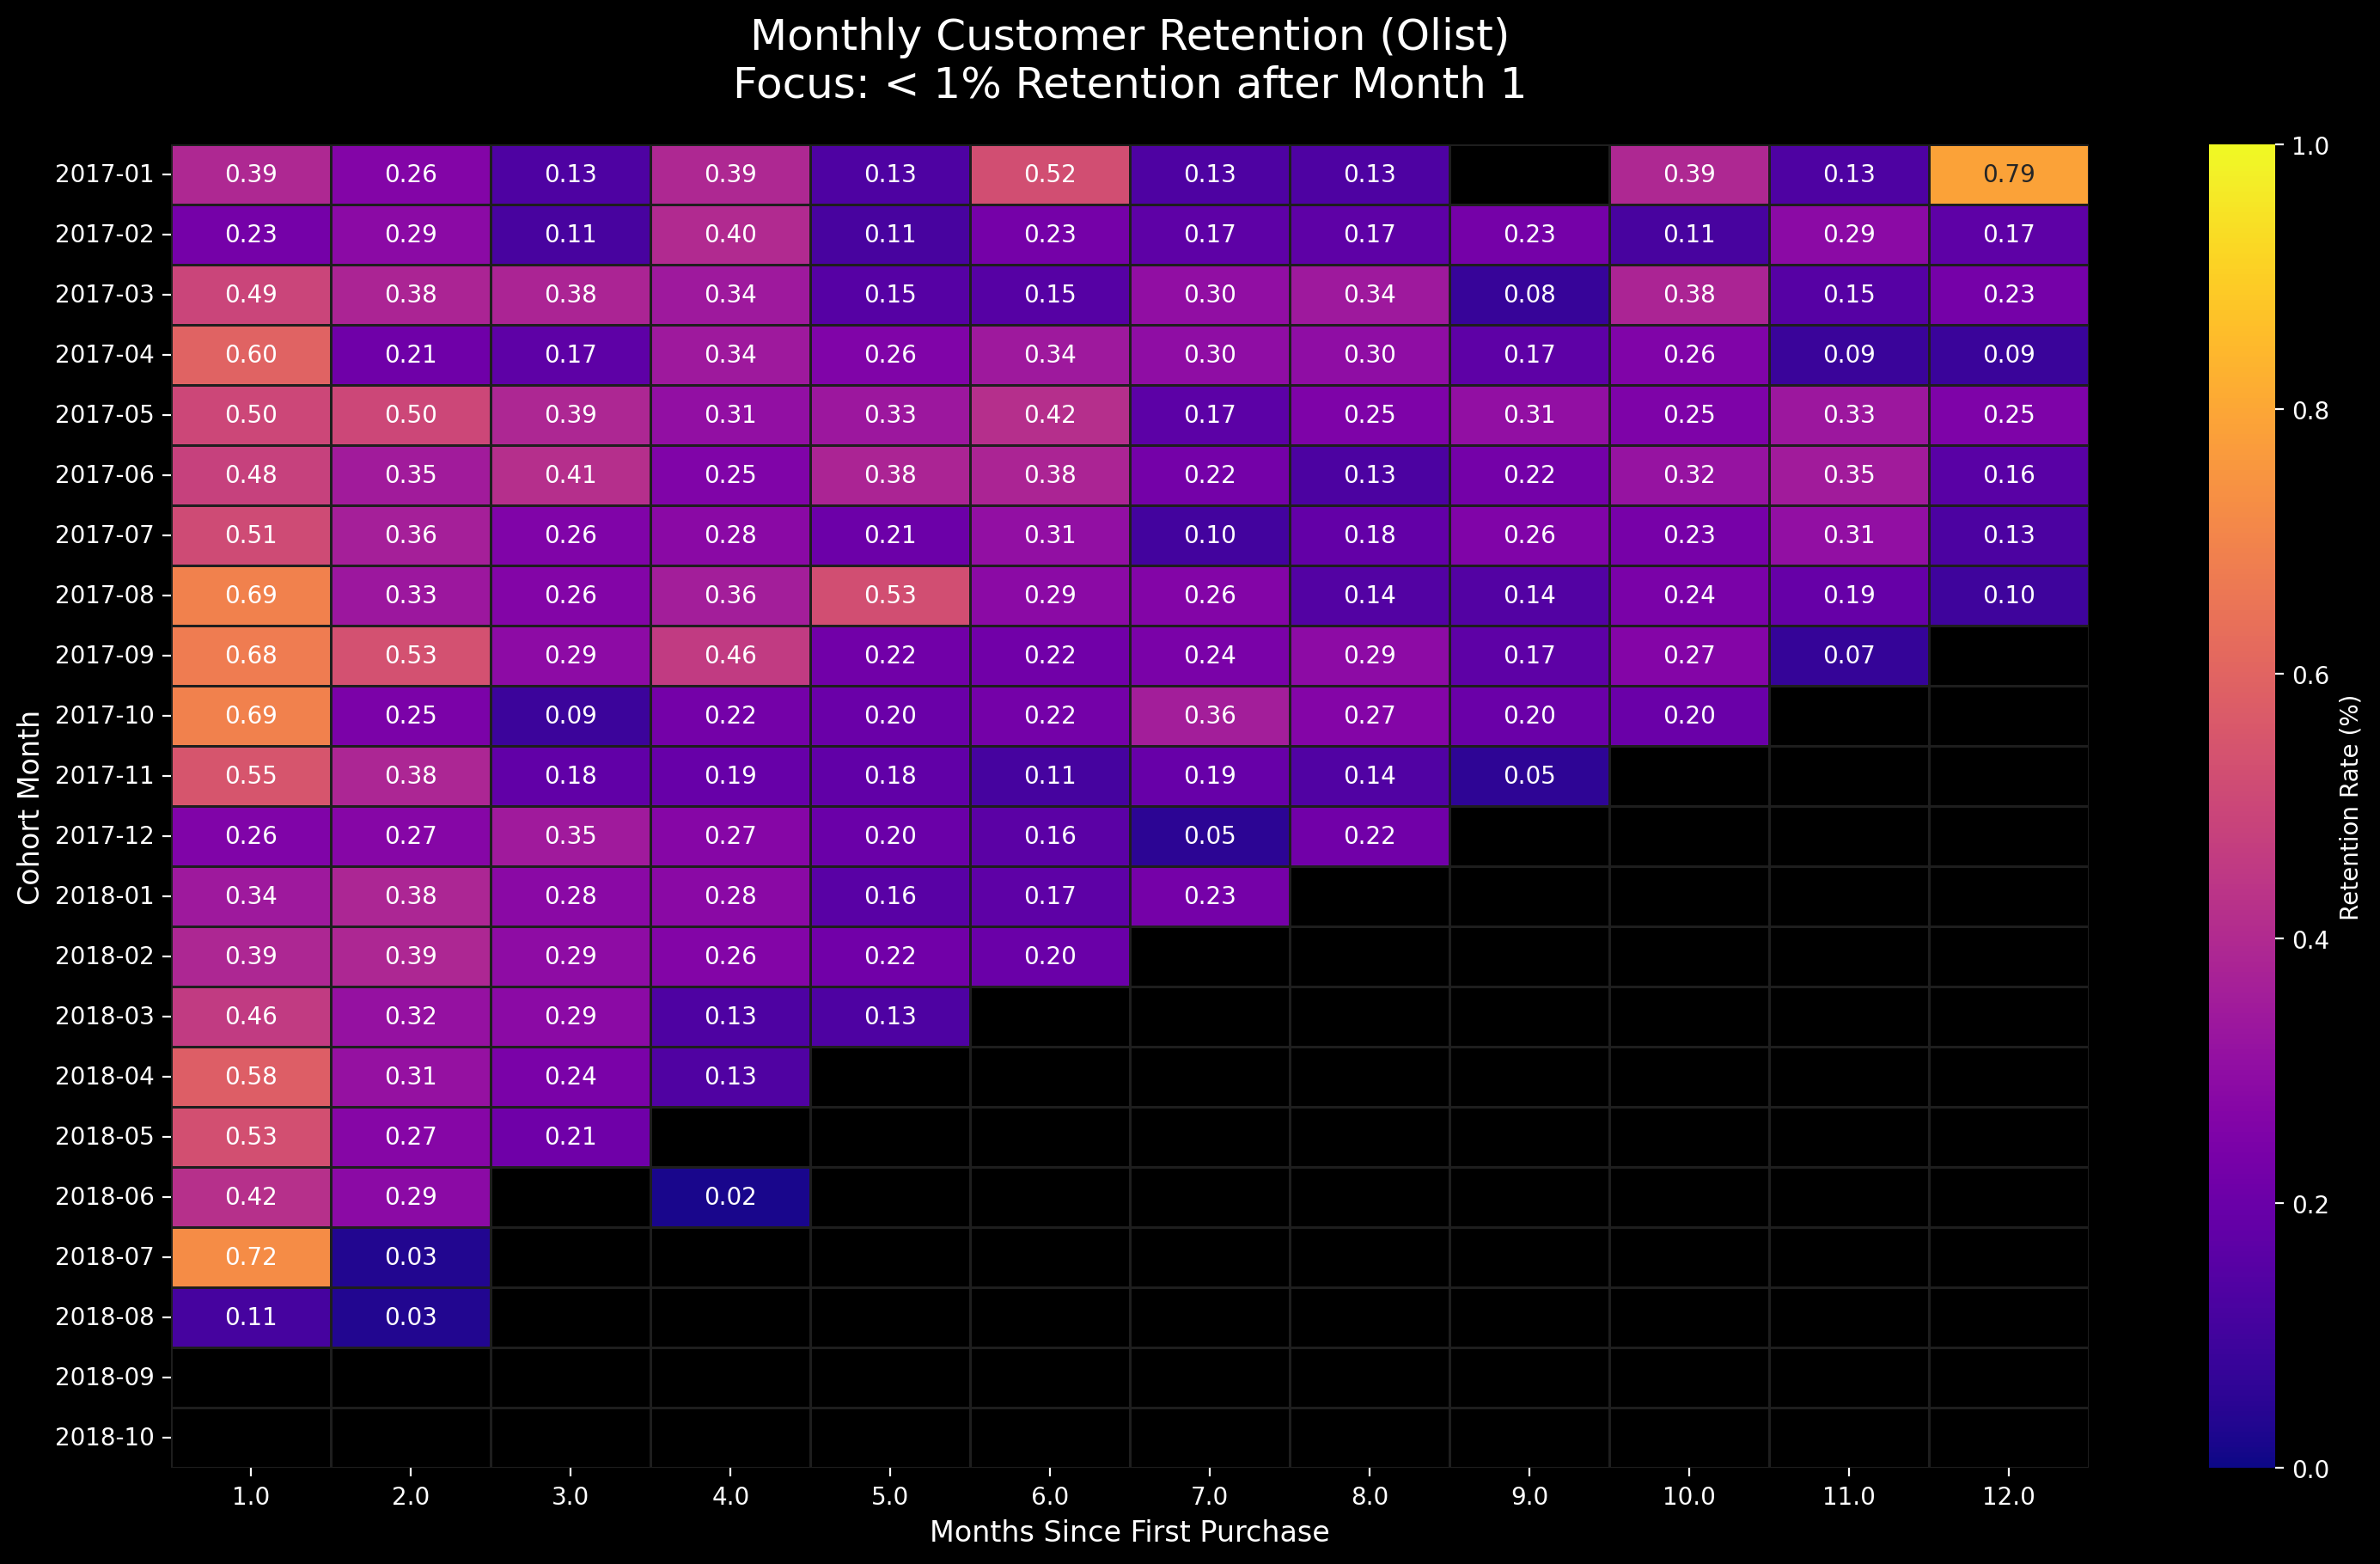

In [3]:
print("📊 Generating Heatmap...")

plt.figure(figsize=(18, 10))

sns.heatmap(
    retention_matrix,
    annot=True,
    fmt='.2f',
    cmap='plasma',
    vmin=0.0,
    vmax=1.0, # Cap at 1% to highlight the critical drop
    linewidths=0.5,
    linecolor='#1e1e1e', # Matches dark background slightly better
    cbar_kws={'label': 'Retention Rate (%)'}
)

plt.title('Monthly Customer Retention (Olist)\nFocus: < 1% Retention after Month 1', fontsize=18, pad=20)
plt.ylabel('Cohort Month', fontsize=12)
plt.xlabel('Months Since First Purchase', fontsize=12)
plt.yticks(rotation=0)

plt.show()

In [4]:
# --- CONCLUSION ---
avg_retention_m1 = retention_matrix[1].mean()

print(">>> COHORT ANALYSIS COMPLETED")
print(f"Key Metric: Average Retention in Month 1 is {avg_retention_m1:.2f}%.")
print("NOTE: Strategic implications of this low retention rate are detailed in README.md")

>>> COHORT ANALYSIS COMPLETED
Key Metric: Average Retention in Month 1 is 0.48%.
NOTE: Strategic implications of this low retention rate are detailed in README.md
